# High-resolution retrieval workflow with `SpectralModel`

Written by [Doriann Blain](mailto:doriann.blain@gmail.com), based on the setup used in [Blain et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167..179B/abstract).

The goal of this notebook is to go through a typical high-resolution retrieval workflow with `SpectralModel`. More details on the `SpectralModel` object are available in the [SpectralModel notebook](./spectral_model.html).

We make some useful imports below.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst
from petitRADTRANS.plotlib import plot_result_corner
from petitRADTRANS.retrieval.preparing import polyfit
from petitRADTRANS.retrieval.retrieval import Retrieval
from petitRADTRANS.spectral_model import SpectralModel

## Optional: loading a `Planet`

It can be convenient to use the [Planet object](./planet.html) to get the parameters we need. Note that this is not required.

In [2]:
from petitRADTRANS.planet import Planet

planet = Planet.get('HD 189733 b')

## Loading data

The first step of any retrieval is to load the data to be retrieved. In a real case, this would be done with something in the line of:

```python
# Load the wavelengths, spectra, and uncertainties (errors)
data_wavelengths, data, data_uncertainties = load('my_data_file')
```

With the `load` function replaced with the steps necessary to load the data, that can be contained in one (or several) `'my_data_file'` file(s). The shape of `data` and `data_uncertainties` must be `(n_orders, n_exposures, n_wavelengths)`. The shape of `data_wavelengths` must be `(n_orders, n_wavelengths)`.

Additional information, like airmass and orbital phases, are also useful for the analysis. If not available, these parameters can be obtained using the [Planet object](./planet.html) built-in functions. Some functions of interest are:

- `Planet.calculate_airmass`: calculate the airmass of an observation site from the exposures' timestamps,
- `Planet.calculate_barycentric_velocities`: calculate the barycentric velocity of an observation site from the exposures' timestamps,
- `Planet.calculate_mid_transit_time`: calculate the primary mid transit time from the day of observation,
- `Planet.calculate_orbital_phases`: calculate the orbital phases from the mid primary transit time and the exposures' timestamps,
- `Planet.calculate_radial_velocity_semi_amplitude`: calculate the planet's $K_p$ from the planet's orbital parameters.

If you are only interested in real data analysis, you can directly skip to [this section](#Preparing-the-data).

In the next section, we will generate **simulated observations**. This step is not necessary to analyse real data.

## Optional: generating simulated observations

Here we do not have real data, so we will generate simulated data.

To build simulated data, we can add telluric transmittances, stellar lines, instrumental deformations, and noise. To do this, we can make use of the following arguments:

- `telluric_transmittances`: telluric transmittances to combine with the spectrum. Those can make use of the `airmass` model parameter to automatically build time- and wavelength-varying transmittances. A good place to download telluric transitances is the [SKYCALC](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) website. petitRADTRANS also has a module to directly download SKYCALC data, calculate the airmass, and even find the best day for your observations in the module `petitRADTRANS.cli.eso_skycalc_cli`.
- `telluric_transmittances_wavelengths`: wavelengths of the provided telluric transmittances.
- `instrumental_deformations`: time and wavelength matrix of the instrumental deformations. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.
- `noise_matrix`: time and wavelength matrix of noise. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.

We will generate mock data wavelengths and times below. We will assume that we observed 19 exposures. We will get the star radial velocities, the barycentric velocities, and the airmass from our `Planet` object. We will let `SpectralModel` calculate the $K_p$ for us, and we will fix `rest_frame_velocity_shift` to -5 km.s-1.

In [3]:
from petitRADTRANS.math import resolving_space

n_exposures = 19

data_wavelengths = resolving_space(1.519, 1.522, 2e5) * 1e-4 # (cm) generate wavelengths at a constant resolving power
data_uncertainties = 1/15000 * np.ones((1, n_exposures, data_wavelengths.size))  # uncertainties assuming a S/N of 15000

times = 0.85 * planet.transit_duration * (np.linspace(0, 1, n_exposures) - 0.5)  # covering 85% of the transit duration
mid_transit_time = 2458004.424877  # (JD)

dates = mid_transit_time + times / cst.s_cst.day
orbital_phases = times / planet.orbital_period

# Get V_* and V_bary from Planet
star_radial_velocity = planet.star_radial_velocity  # (cm.s-1) V_sys
barycentric_velocities = planet.calculate_barycentric_velocities(
    time=dates,
    site_name='CAHA',
    time_format='jd'
)

# High resolution telluric transmittances (typically downloaded from SKYCALC)
telluric_transmittances_wavelengths = resolving_space(1.515, 1.525, 1e6) * 1e-4
telluric_transmittances = np.ones(telluric_transmittances_wavelengths.size)

telluric_transmittances[2850:2870] = 0.85
telluric_transmittances[2900:2930] = 0.7
telluric_transmittances[3400:3500] = 0.1
telluric_transmittances[3900:3950] = 0.5
telluric_transmittances[4400:4475] = 0.3

# Uncertainties are usually smaller within the telluric and stellar lines
telluric_transmittances_interp = np.interp(data_wavelengths, telluric_transmittances_wavelengths, telluric_transmittances)
data_uncertainties *= telluric_transmittances_interp

# Calculate the airmass using the Planet function
airmass = planet.calculate_airmass(
    time=dates,
    site_name='CAHA',
    time_format='jd'
)

# Random wavelength-constant instrumental deformations (typically unknown on real data), we use a seed for reproducibility
instrumental_deformations = (0.4 - 0.2) * np.random.default_rng(seed=12345).random(n_exposures) + 0.2
instrumental_deformations = np.repeat(instrumental_deformations[:, np.newaxis], data_wavelengths.size, axis=-1)

# Noise with the data uncertainties, we use a seed for reproducibility
noise_matrix = np.random.default_rng(seed=54321).normal(loc=0, scale=data_uncertainties)

Now let's initalize our simulated data. We will add an opaque cloud layer at 100 mbar. Our instrument will have a resolving power of $R = 80\,000$.
<div class="alert alert-info">

**Model parameter** `wavelength_boundaries`**:** if you provide parameters such as the wavelengths of your data (`rebinning_wavelengths`), you no longer need to manually set `wavelength_boundaries`: `SpectralModel` will automatically calculate the optimal wavelengths boundaries for your data, taking into account the effect of time-varying Doppler-shift.
</div>

We will use `planet` to get some of the required parameters.

In [4]:
data_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CO-NatAbund', 
        'H2O' 
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    line_opacity_mode='lbl',
    line_by_line_opacity_sampling=4,
    # Model parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    transit_duration=planet.transit_duration,
    orbital_period=planet.orbital_period,
    # Velocity paramters
    star_mass=planet.star_mass,
    orbit_semi_major_axis=planet.orbit_semi_major_axis,
    orbital_inclination=planet.orbital_inclination,
    rest_frame_velocity_shift=-5e5,  # (cm.s-1) V_rest
    system_observer_radial_velocities=star_radial_velocity - barycentric_velocities,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e-2,  # added opaque cloud
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CO-NatAbund': 1e-2,
        'H2O': 1e-3,
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=data_wavelengths,  # (cm) used for the rebinning, and also to set the wavelengths boundaries
    rebin_range_margin_power=4,  # used to set the wavelengths boundaries, adding a margin of ~1 Angstrom (1e-4 * ~1 µm)
    convolve_resolving_power=8e4,  # used for the convolution
    mid_transit_time=0,  # (s) the time of mid transit relative to the "times" parameter, **not** the real mid transit time in JD
    times=times,
    # Preparation parameters
    airmass=airmass,
    tellurics_mask_threshold=0.8,  # mask the fitted transmittances if it is below this value
    polynomial_fit_degree=2,  # degree of the polynomial fit
    uncertainties=data_uncertainties
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded 

Now we can generate the simulated data. We will use **noiseless** simulated data to check the accuracy of our retrieval setup.

In [5]:
# Get simulated noiseless data (instead you would load the data here)
data_wavelengths, data = data_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=None,  # no noise so we can see the lines
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=False  # if the data were loaded, a preparation could not be done rigth away
)

# The data and its uncertainties must be masked arrays
data = np.ma.masked_array(data)
data_uncertainties = np.ma.masked_array(data_uncertainties)

# You can mask for example invalid pixels, here we will mask nothing
data.mask = np.zeros(data.shape, dtype=bool)
data_uncertainties.mask = np.zeros(data_uncertainties.shape, dtype=bool)

## Preparing the data

A crucial step to analyze these data is to clean the effect of the telluric and stellar lines, and of the instrumental deformations. This is done using a "preparing pipeline" (also called "detrending" or "pre-processing" step).

The [Polyfit](https://ui.adsabs.harvard.edu/abs/2024AJ....167..179B/abstract) preparing pipeline can be used, it is also the default `SpectralModel.preparing_pipeline` function. The well-known [SysRem](https://ui.adsabs.harvard.edu/abs/2005MNRAS.356.1466T/abstract) preparing pipeline is also implemented.

<div class="alert alert-info">

**Using SysRem instead of Polyfit:** an example to setup `SpectralModel` to use SysRem is provided in the [`SpectralModel` notebook](./spectral_model.ipynb). Note that we **do not** recommend to use SysRem with this framework (see [Blain et al. 2024](https://ui.adsabs.harvard.edu/abs/2024AJ....167..179B/abstract), Appendix B).
</div>

Text(0.5, 1.0, 'Prepared noiseless data')

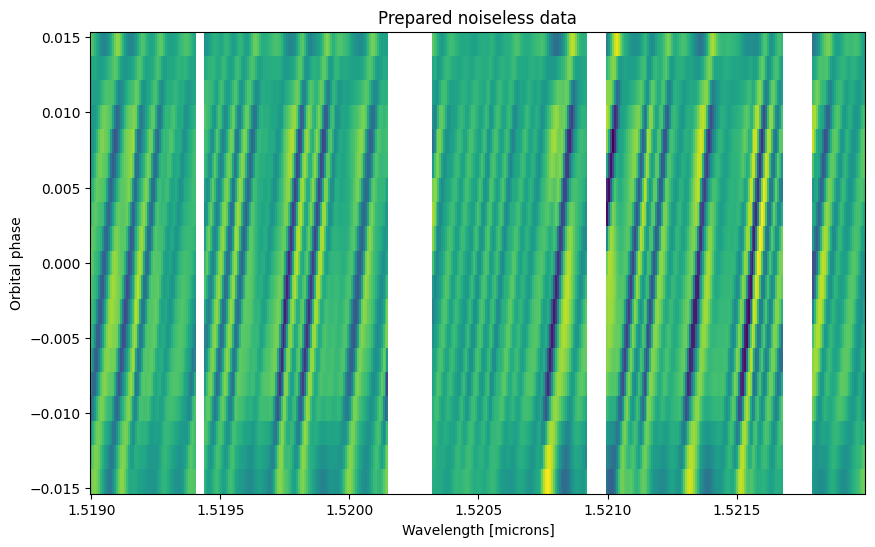

In [6]:
prepared_data, preparation_matrix, prepared_data_uncertainties = polyfit(
    spectrum=data,
    uncertainties=data_uncertainties,
    wavelengths=data_wavelengths,
    airmass=airmass,
    tellurics_mask_threshold=0.8,
    polynomial_fit_degree=2,
    full=True,
    apply_throughput_removal=True,
    apply_telluric_lines_removal=True
)

# Plot the prepared data
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(data_wavelengths[0] * 1e4, orbital_phases, prepared_data[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title('Prepared noiseless data')

## Defining the retrieved parameters

Let's define the parameters we will retrieve. We will retrieve the temperature, the abundance of our line species, the pressure of the cloud, as well as $K_p$, $V_\textrm{rest}$, and $T_0$. We will use uniform prior in all cases. This is typical for a retrieval, although it can be relevant to use more complex priors in some rare and specific case. In the `SpectralModel` workflow, we only need to sepcify which of our `model_parameters` we would like to retrieve, and how.

<div class="alert alert-info">
    
Note that **any** model parameter can be retrieved in this way. It could be interesting to retrieve, e.g., `convolve_resolving_power` or `reference_gravity`. For this example, we will limit the number of retrieved parameters. But in a real case, you just need to add the name and prior parameters in the `retrieved_parameters` dictionary.
</div>

In [7]:
retrieved_parameters = {
    'temperature': {
        'prior_parameters': [100, 4000],  # (K)
        'prior_type': 'uniform',
        'figure_title': r'T',
        'figure_label': r'T (K)'
    },
    'CO-NatAbund': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CO]',
        'figure_label': r'$\log_{10}$(MMR) CO'
    },
    'H2O': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[H$_2$O]',
        'figure_label': r'$\log_{10}$(MMR) H$_2$O'
    },
    'log10_opaque_cloud_top_pressure': {
        'prior_parameters': [-10, 2],  # (bar)
        'prior_type': 'uniform',
        'figure_title': r'[$P_c$]',
        'figure_label': r'$\log_{10}(P_c)$ ([Pa])',
        'figure_offset': 5  # [bar] to [Pa]
    },
    'radial_velocity_semi_amplitude': {
        'prior_parameters': np.array([100e5, 200e5]),  # (cm.s-1)
        'prior_type': 'uniform',
        'figure_title': r'$K_p$',
        'figure_label': r'$K_p$ (km$\cdot$s$^{-1}$)',
        'figure_coefficient': 1e-5  # cm.s-1 to km.s-1
    },
    'rest_frame_velocity_shift': {
        'prior_parameters': np.array([-10e5, 10e5]),  # (cm.s-1)
        'prior_type': 'uniform',
        'figure_title': r'$V_\mathrm{rest}$',
        'figure_label': r'$V_\mathrm{rest}$ (km$\cdot$s$^{-1}$)',
        'figure_coefficient': 1e-5  # cm.s-1 to km.s-1
    },
    'mid_transit_time': {
       'prior_parameters': np.array([-150, 150]),  # (s)
       'prior_type': 'uniform',
       'figure_title': r'$T_0$',
       'figure_label': r'$T_0$)'
    }
}

The retrieved parameters dictionary follows these rules:

- Each key must refer to the desired `model_parameters` to retrieve.
- The value of each key must be a dictionary containing at least the following keys:
    - `'prior_type'`: a string stating the prior type to use. See `petitRADTRANS.retrieval.utils` to get a list of them.
    - `'prior_parameters'`: a list of values, one for each of the prior function parameters.

<div class="alert alert-info">
    
**Log10 retrieval:** if you want to retrieve the decimal logarithm of a parameter instead of the parameter itself, you can add `log10_` in front of its model parameter name. For example, `log10_opaque_cloud_top_pressure` instead of `opaque_cloud_top_pressure`. `SpectralModel` will make the conversion automatically. The imposed mass fraction are automatically retrieved in log-space and the species names **must not** be altered.
</div>

<div class="alert alert-warning">
    
The name to use for the retieved parameters must be the same name as the corresponding `model_parameters`, **with one exception**: the imposed mass fractions species must be **directly** named and **not** put inside a `imposed_mass_fractions` dictionary.
</div>

Other keys can be added, but they are optional and used only for [plotting](#plotting):

- `'figure_title'`: text to display above each posterior in the corner plot
- `'figure_label'`: text to display at the bottom of each posterior in the corner plot
- `'figure_coefficient'`: coefficient by which to multiply the posterior's value in the corner plot
- `'figure_offset'`: value by which to offset the posterior's value in the corner plot

## The forward model: a `SpectralModel` with velocity range

A high-resolution retrieval is a computationally expensive task. A way to optimize the retrieval time is to make use of `SpectralModel`'s optimal wavelength boundaries calculation.

However, because we will be exploring a **range** of velocities (through $K_p$ and $V_\textrm{rest}$) in this retrieval, we cannot simply instantitate our `SpectralModel` by giving one value for `radial_velocity_semi_amplitude`, `rest_frame_velocity_shift`, and `mid_transit_time`. Fortunately, we can instantiate `SpectralModel` using the initializing function `with_velocity_range` to take care of that. 

Because we used uniform priors, that are parameterized by their lower and upper boundaries, we can directly use `retrieved_parameters`. With other priors, such as `gaussian`, this would be more difficult.

In [8]:
forward_model = SpectralModel.with_velocity_range(
    # Velocity parameters
    radial_velocity_semi_amplitude_range=retrieved_parameters['radial_velocity_semi_amplitude']['prior_parameters'],
    rest_frame_velocity_shift_range=retrieved_parameters['rest_frame_velocity_shift']['prior_parameters'],
    mid_transit_times_range=retrieved_parameters['mid_transit_time']['prior_parameters'],
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CO-NatAbund', 
        'H2O' 
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    line_opacity_mode='lbl',
    line_by_line_opacity_sampling=4,
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    transit_duration=planet.transit_duration,
    orbital_period=planet.orbital_period,
    # Velocity paramters
    star_mass=planet.star_mass,
    orbit_semi_major_axis=planet.orbit_semi_major_axis,
    orbital_inclination=planet.orbital_inclination,
    rest_frame_velocity_shift=0,  # (cm.s-1) V_rest
    system_observer_radial_velocities=star_radial_velocity - barycentric_velocities,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e-2,  # added opaque cloud
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CO-NatAbund': 1e-12,
        'H2O': 1e-12,
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=data_wavelengths,  # (cm)
    rebin_range_margin_power=4,  # increase the margin of the optimal wavelengths boundaries by ~1 angstrom (1e-4 * 1 um)
    convolve_resolving_power=8e4,  # used for the convolution
    mid_transit_time=0,
    times=times,
    # Preparation parameters
    airmass=airmass,
    tellurics_mask_threshold=0.8,  # mask the fitted transmittances if it is below this value
    polynomial_fit_degree=2,  # degree of the polynomial fit
    uncertainties=data_uncertainties
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded 

## Setting up the retrieval

The `SpectralModel` workflow uses the same objects (`Data`, `Retrieval`) as the `Radtrans` retrieval workflow, but uses them a bit differently. A description of these objects is available in the ["Basic Retrieval Tutorial"](./retrieval_basic.html).

### Instantiating a `Data` object from a `SpectralModel` object

The `Data` object combines the data with an associated forward model, here, `forward_model`. During the retrieval, `forward_model` will be used to fit the data. The fixed parameters of the retrieval are the **model parameters** of `forward_model` that are not in `retrieved_parameters`.

The modifications performed on the data during the preparing step has an effect on the uncertainties, hence we use the **uncertainties of the prepared data** that were returned by polyfit.

In [9]:
data = {  # multiple data can be retrieved by adding multiple keys
    'data_1': forward_model.init_data(
        # Data parameters
        data_spectrum=prepared_data,
        data_wavelengths=data_wavelengths,
        data_uncertainties=prepared_data_uncertainties,
        data_name='data_1',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        # Forward model post-processing parameters
        mode='transmission',
        update_parameters=True,
        scale=True,
        shift=True,
        use_transit_light_loss=True,
        convolve=True,
        rebin=True,
        prepare=True
    )
}

Taking care of mask...


### Instantiating a `Retrieval` object from a `Data` object

Now let's make a `Retrieval` object from `data`.

In [10]:
retrieval_name = 'spectral_model_example'
retrieval_directory = os.path.join('.', 'results', retrieval_name)

retrieval = Retrieval.from_data(
    data=data,
    retrieved_parameters=retrieved_parameters,
    retrieval_name=retrieval_name,
    output_directory=retrieval_directory,
    run_mode='retrieval'
)

Using provided Radtrans object for data 'data_1'...


## Running the retrieval

Let's run the retrieval. We will use very few live points and data points for speed. In a real high-resolution case, 100 live points can be enough to obtain reasonably defined posteriors.

This example should run in a several minutes on multiple processes, but a typical retrieval on a cluster can take several hours, depending mostly on the number of live points, the number of retrieved parameters, and the number of CPUs used.

In [ ]:
%%time
retrieval.run(
    n_live_points=30,
    resume=False,
    seed=12345  # ⚠️ seed should be removed or set to -1 in a real retrieval, it is added here for reproducibility
)

Starting retrieval spectral_model_example
Testing data 'data_1':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing model function for data 'data_1'...
No errors detected in the model functions!
Starting retrieval: spectral_model_example

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =   30
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.666667
Replacements:                                 80
Total Samples:                               120
Nested Sampling ln(Z):                -55.462837
Importance Nested Sampling ln(Z):     -56.202810 +/-  0.155701
Acceptance Rate:            

<div class="alert alert-info">

In real high-resolution retrievals, it is not rare for the log-evidence (`ln(Z)`) printed by MultiNest to be `*********`. This is because high-resolution data contains a lot of points ($\approx 10^6$), so the absolute value of the log-evidence can reach very large values. Here the printed log-evidence should be small because of the few number of data points, but most importantly because we used noiseless data.
</div>

## Plotting a corner plot

Now we just have use a corner plot to visualize the results.

Since we used simulated data, we can check if we correctly retrieved the parameters by adding the `true_values` argument. In a retrieval on real data, the true parameters are unknown, so `true_values` can be left to `None`.

The posteriors will probably not be very well defined because of the few number of live points we used and insufficient S/N.

In [ ]:
true_parameters = data_model.get_true_parameters(retrieved_parameters)  # get our simulated data true parameters

plot_result_corner(
    retrieval_directory=[
        retrieval_directory
    ],
    retrieved_parameters=retrieved_parameters,
    figure_name='corner_plot',
    label_kwargs={'fontsize': 16},
    title_kwargs={'fontsize': 14},
    figure_font_size=12,
    true_values=true_parameters,
    save=True, 
    figure_directory=retrieval_directory,  
    image_format='png'
)

## Best fit model and best fit parameters

We can obtain the best fit model (i.e., the model with the maximum log-likelihood) very easily with the `Retrieval.calculate_forward_model` function:

In [ ]:
# Get the forward model with best-fit parameters
wavelengths, best_fit_spectra, _ = retrieval.calculate_forward_model(
    parameters='best fit', 
    data='data_1'
)

# Get the forward model with median parameters
_, median_spectra, _ = retrieval.calculate_forward_model(
    parameters='median', 
    data='data_1'
)

# Get the forward model with the true parameters
_, true_spectra, _ = retrieval.calculate_forward_model(
    parameters=true_parameters,  # a dictionary can also be used, with parameter (fixed and/or free) names as keys
    data='data_1'
)

# Plot at T0 = 0
i_t0 = int(np.round(orbital_phases.size / 2))

fig, axes = plt.subplots(nrows=2, sharex='all', figsize = (10,6))

axes[0].plot(wavelengths[0] * 1e4, true_spectra[0, i_t0], ls='-', color='C2', label='"True" spectrum')
axes[0].plot(wavelengths[0] * 1e4, median_spectra[0, i_t0], ls='-', color='C0', label='Median spectrum')
axes[0].plot(wavelengths[0] * 1e4, best_fit_spectra[0, i_t0], ls='-', color='r', label='Best-fit spectrum')
axes[0].plot(wavelengths[0] * 1e4, prepared_data[0, i_t0], ls='--', color='k', label='Data')

fig.legend()

axes[1].plot(wavelengths[0] * 1e4, (true_spectra[0, i_t0] - prepared_data[0, i_t0]) / prepared_data_uncertainties[0, i_t0], ls='-', color='C2', label='"True" spectrum')
axes[1].plot(wavelengths[0] * 1e4, (median_spectra[0, i_t0] - prepared_data[0, i_t0]) / prepared_data_uncertainties[0, i_t0], ls='-', color='C0', label='Median spectrum')
axes[1].plot(wavelengths[0] * 1e4, (best_fit_spectra[0, i_t0] - prepared_data[0, i_t0]) / prepared_data_uncertainties[0, i_t0], ls='-', color='r', label='Best-fit spectrum')

axes[0].set_title(rf'Comparison with best fit model ($\phi = {orbital_phases[i_t0]:.2f}$)')
axes[0].set_ylabel('Spectrum [A.U.]')
axes[1].set_xlabel('Wavelength [microns]')
axes[1].set_ylabel(r'Residuals ($\sigma$)')

<div class="alert alert-info">

The residuals between the data and the spectrum with the true parameters are not 0. This is because our (simulated) data have tellurics and deformations, while our forward model have not. Since our preparing pipeline is imperfect, this creates some differences between the spectra.
</div>

Because we retrieved simulated **noiseless** data, the residuals are extremely small. The reduced $\chi^2$ is close to 0. On noisy (real) data, the reduced $\chi^2$ should be close to 1.

The best fit parameters, as well as the maximum likelihood and the best fit $\chi^2$ can be obtained as follows:

In [ ]:
best_fit_parameters, max_likelihood, chi2 = retrieval.get_best_fit_parameters(return_max_likelihood=True)

print(f"Best fit reduced chi2 against the prepared data: {chi2 / (prepared_data.size - len(retrieved_parameters)):.2e} (from Log(L) = {max_likelihood:.2f})")

print("\nBest fit parameters (truth):")

for parameter_name, value in best_fit_parameters.items():
    print(f"    - '{parameter_name}': {value:.3f} ({true_parameters[parameter_name]:.3f})")

<div class="alert alert-info">

It is not unusual for the best fit parameters to be different from the truth. This is again caused by the imperfect preparing pipeline. Because the forward model with the true parameters is not exactly equal to the simulated data, there is room for the retrieval to find pseudo-improvment of the fit. The median retrieved parameters should be considered more reliable. In any case, any preparing pipeline should be tested in order to ensure that its imperfections are not biassing the retrieval.
</div>

More generally, the retrieval samples can be obtained with the `get_samples_dict` function.

In [ ]:
samples = retrieval.get_samples_dict()

fig, ax = plt.subplots(figsize = (3,3))
ax.hist(samples['H2O'], density=True, histtype='step')
ax.set_xlabel(retrieved_parameters['H2O']['figure_label'])
ax.set_ylabel('Probability density')